# Question 3a)

In [168]:
# import necessary libraries 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller

df = pd.read_excel('RSGCS.xlsx',header=0)
df['QUARTER'] = pd.PeriodIndex(df['QUARTER'], freq='Q')
df = df.set_index('QUARTER').sort_index()

# filter to the 2009Q4 only 
# Option 1: label‐based slicing with .loc
df_trunc = df.loc[:'2009Q4']


df_trunc = df_trunc[['HPCYCLE']].dropna()

df_trunc.head()


,HPCYCLE
QUARTER,
1992Q1,0.000739
1992Q2,0.001542
1992Q3,0.004592
1992Q4,0.003948
1993Q1,-0.002029


### ACF, PACF investigation

 lag     ACF    PACF
   1  0.729*  0.729*
   2  0.507*  -0.052
   3   0.209 -0.304*
   4  -0.011  -0.090
   5  -0.134   0.045
   6  -0.134   0.110
   7  -0.127  -0.083
   8  -0.081  -0.034
   9  -0.087  -0.088
  10  -0.188 -0.256*
  11 -0.253*  -0.026
  12 -0.389*  -0.222
  13 -0.367*   0.109
  14 -0.390*  -0.222
  15 -0.299*  -0.033
  16 -0.272*  -0.203
  17  -0.158   0.035
  18  -0.093  -0.014
  19  -0.044  -0.167
  20   0.005   0.022


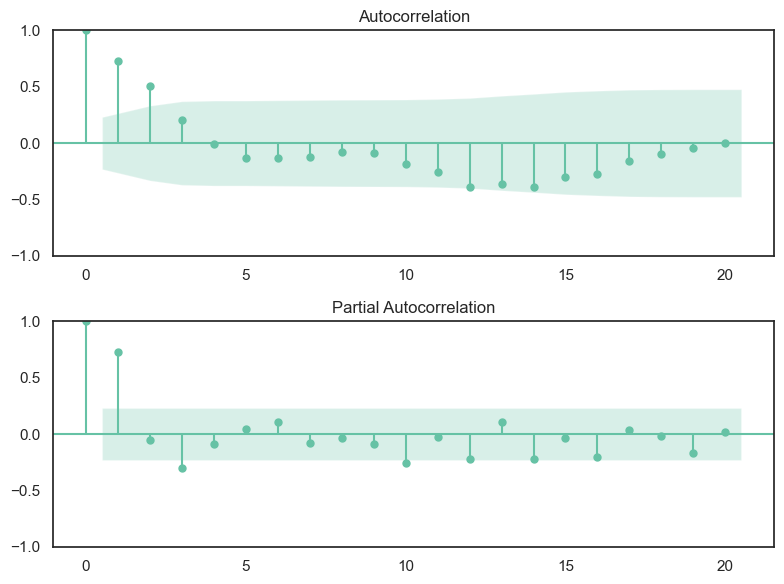

In [169]:
ts = df_trunc.copy()

nlags = 20
T = len(ts)

# --- compute ACF/PACF (we don’t need their Bartlett‐CI here) ---
acf_vals = acf(ts, nlags=nlags, fft=False)
pacf_vals = pacf(ts, nlags=nlags, method="ywmle")

# --- Ljung–Box for reference ---
lb = acorr_ljungbox(ts, lags=nlags, return_df=True)

# --- strict‐white‐noise threshold ---
thresh = 1.96/np.sqrt(T)

# --- build table ---
rows = []
for k in range(1, nlags+1):
    a = acf_vals[k]
    p = pacf_vals[k]
    rows.append({
        "lag": k,
        "ACF": f"{a:.3f}{'*' if abs(a)>thresh else ''}",
        "PACF": f"{p:.3f}{'*' if abs(p)>thresh else ''}",
    })

table = pd.DataFrame(rows)
print(table.to_string(index=False))

# 5) optionally plot ACF & PACF
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
sm.graphics.tsa.plot_acf(ts, lags=nlags, ax=axes[0])
sm.graphics.tsa.plot_pacf(ts, lags=nlags, ax=axes[1])
plt.tight_layout()
plt.savefig('ACF_PACF.png')
plt.show()

### ADF test

In [170]:
# --- ADF test: no constant/trend, SIC‐based lag selection ---
result = adfuller(
    ts,
    maxlag=None,        # let autolag choose up to the default maximum
    regression='n',     # no constant, no trend
    autolag='BIC'       # Schwarz (SIC) criterion
)

# unpack results
adf_stat, p_value, used_lag, nobs, crit_vals, icbest = result

print(f"ADF stat:   {adf_stat:.4f}")
print(f"p‐value:    {p_value:.4f}")
print(f"lags used: {used_lag}")
print("critical values:")
for name, cv in crit_vals.items():
    print(f"   {name}: {cv:.3f}")
print(f"SIC of best model: {icbest:.3f}")

ADF stat:   -3.1415
p‐value:    0.0017
lags used: 0
critical values:
   1%: -2.598
   5%: -1.945
   10%: -1.614
SIC of best model: -416.585


In [171]:
y = df_trunc['HPCYCLE'].dropna()
T = len(y)

# --- 2) build dummies as pandas Series ---
date1 = pd.Period('2000Q1', freq='Q')
date2 = pd.Period('2008Q3', freq='Q')
d1 = pd.Series((y.index == date1).astype(int), index=y.index)
d2 = pd.Series((y.index == date2).astype(int), index=y.index)

# --- 3) form the ADF data: Δy and y_{t-1} ---
# we drop the first observation after differencing
dy = y.diff().iloc[1:]
y_lag = y.shift(1).iloc[1:]
d1 = d1.iloc[1:]
d2 = d2.iloc[1:]

# --- 4) search over lags 0…max_lag using BIC ---
max_lag = 20 # or adjust as needed
best_bic = np.inf
best_p = None
best_mod = None

for p in range(max_lag + 1):
    # build regressors
    data = {
        'y_lag': y_lag,
        'D2000Q1': d1,
        'D2008Q3': d2,
    }
    for i in range(1, p + 1):
        data[f'dy_lag{i}'] = dy.shift(i)

    X = pd.DataFrame(data).dropna()
    Y = dy.loc[X.index]

    # no constant or trend
    model = sm.OLS(Y, X).fit()
    bic = model.bic

    if bic < best_bic:
        best_bic = bic
        best_p = p
        best_mod = model

# --- 5) report results ---
print(f"Selected lag length by BIC: p = {best_p}")
print(f"Minimized BIC: {best_bic:.3f}")

# ADF test statistic = t-value on y_{t-1} coefficient
adf_stat = best_mod.tvalues['y_lag']
adf_pvalue = best_mod.pvalues['y_lag']
nobs = best_mod.nobs

print(f"ADF Test Statistic (t on y_lag): {adf_stat:.4f}")
print(f"Approximate p-value: {adf_pvalue:.4f}")
print(f"Number of observations used: {int(nobs)}")

# Show coefficient table for reference
print("Coefficient estimates and diagnostics:")
print(best_mod.summary().tables[1])

Selected lag length by BIC: p = 0
Minimized BIC: -525.538
ADF Test Statistic (t on y_lag): -2.9491
Approximate p-value: 0.0044
Number of observations used: 71
Coefficient estimates and diagnostics:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y_lag         -0.2236      0.076     -2.949      0.004      -0.375      -0.072
D2000Q1       -0.0264      0.006     -4.660      0.000      -0.038      -0.015
D2008Q3        0.0062      0.006      1.062      0.292      -0.005       0.018


## Histograms 

Jarque Bera Statistic: 1.9408804567386009
Jarque Bera p-value: 0.3789161917236546
Jarque Bera Skewness: 0.4021540167594857
Jarque Bera Kurtosis: 2.993018634585877


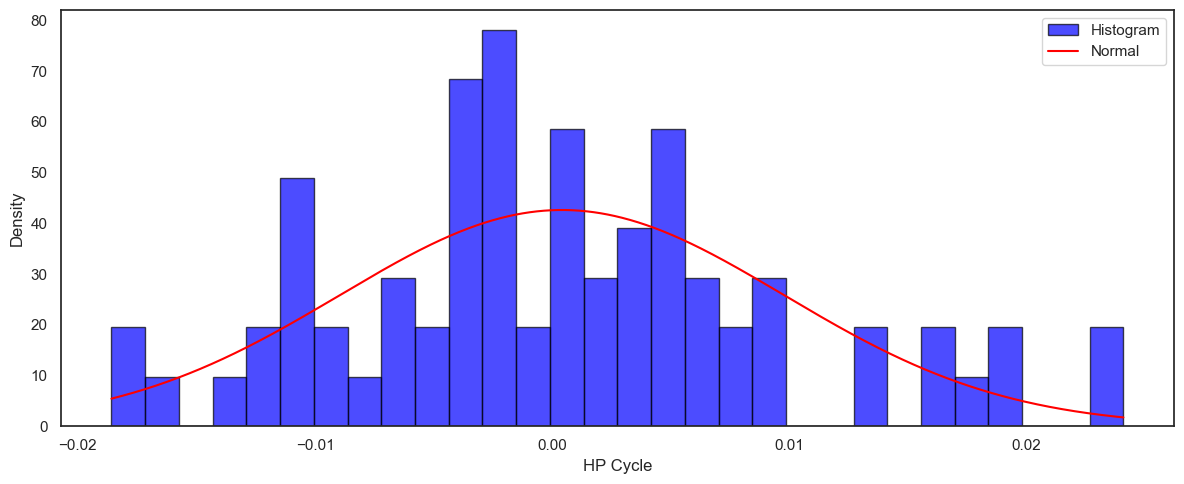

In [172]:
data = df.copy()
# make sure to only consider 1992Q1 - 2009Q4
data_q1 = data.loc["1992Q1":"2009Q4"]
data_q1 = data_q1["HPCYCLE"]

def test_normality(input):
    mean = input.mean()
    median = input.median()
    mn, mx = input.min(), input.max()
    std = input.std()
    skew = input.skew()
    kurt = input.kurtosis()
    jb_stat, jb_pvalue, jb_skew, jb_kurt = jarque_bera(input)

    print(f"Jarque Bera Statistic: {jb_stat}")
    print(f"Jarque Bera p-value: {jb_pvalue}")
    print(f"Jarque Bera Skewness: {jb_skew}")
    print(f"Jarque Bera Kurtosis: {jb_kurt}")
 


    fig, ax_hist = plt.subplots(1, 1, figsize=(12, 5))

    # Histogram with density=True to match the PDF scale
    count, bins, ignored = ax_hist.hist(input, bins=30, density=True, color='blue', edgecolor='black', alpha=0.7, label='Histogram')

    # Normal distribution curve
    x = np.linspace(min(bins), max(bins), 1000)
    normal_pdf = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    ax_hist.plot(x, normal_pdf, 'r-', label='Normal')

    ax_hist.set_xlabel('HP Cycle')
    ax_hist.set_ylabel('Density')
    ax_hist.legend()

    # # Statistics box
    # ax_stats.axis('off')
    # text = (
    #     f'N         {len(input)}\n'
    #     f'Mean      {mean:8.4f}\n'
    #     f'Median    {median:8.4f}\n'
    #     f'Max       {mx:8.4f}\n'
    #     f'Min       {mn:8.4f}\n'
    #     f'Std. Dev. {std:8.4f}\n'
    #     f'Skewness  {jb_skew:8.4f}\n'
    #     f'Kurtosis  {jb_kurt:8.4f}\n'
    #     f'Jarque-Bera  {jb_stat:8.2f}\n'
    #     f'Prob(JB)     {jb_pvalue:.6f}'
    # )
    # ax_stats.text(0.05, 0.95, text, transform=ax_stats.transAxes,
    #               fontsize=10, va='top', family='monospace')

    plt.tight_layout()
    plt.show()


test_normality(data_q1)

Jarque Bera Statistic: 1.3981256597641787
Jarque Bera p-value: 0.49705090683967046
Jarque Bera Skewness: 0.34549422257256535
Jarque Bera Kurtosis: 2.956498991529864


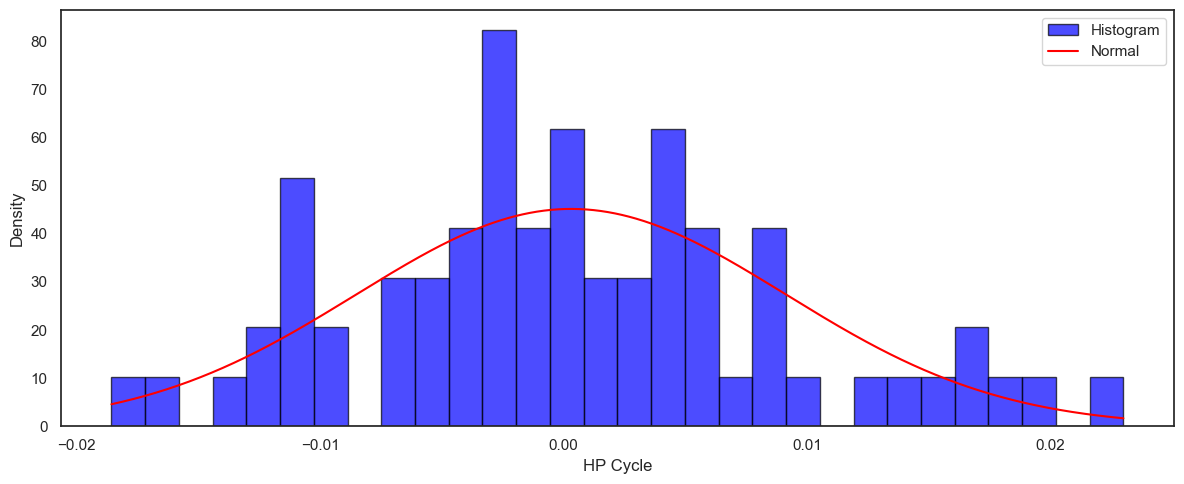

In [173]:
data_q1_excluded = data_q1.drop(pd.Period('2000Q1'), axis=0)
data_q1_excluded = data_q1_excluded.drop(pd.Period('2008Q3'), axis=0)
test_normality(data_q1_excluded)

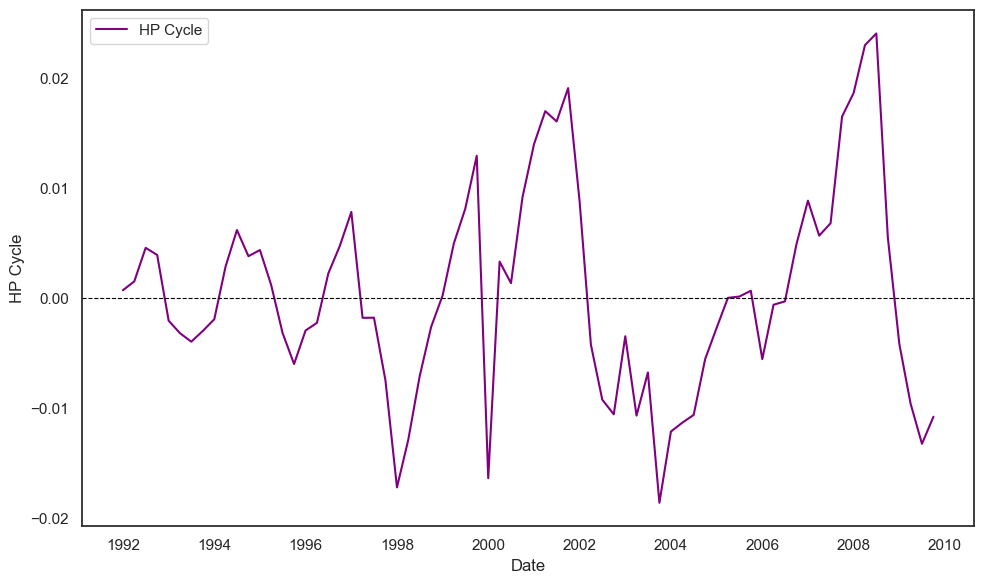

In [174]:
plt.figure(figsize=(10, 6))
plt.plot(data_q1.index.to_timestamp(), data_q1.values, label='HP Cycle', color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

plt.xlabel('Date')
plt.ylabel('HP Cycle')
plt.legend()
plt.tight_layout()
plt.show()

# QUESTION 3b)

## Residual Plot

                            OLS Regression Results                            
Dep. Variable:                HPCYCLE   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     31.06
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           1.41e-12
Time:                        23:36:29   Log-Likelihood:                 254.22
No. Observations:                  69   AIC:                            -500.4
Df Residuals:                      65   BIC:                            -491.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.955e-05      0.001      0.065      0.9

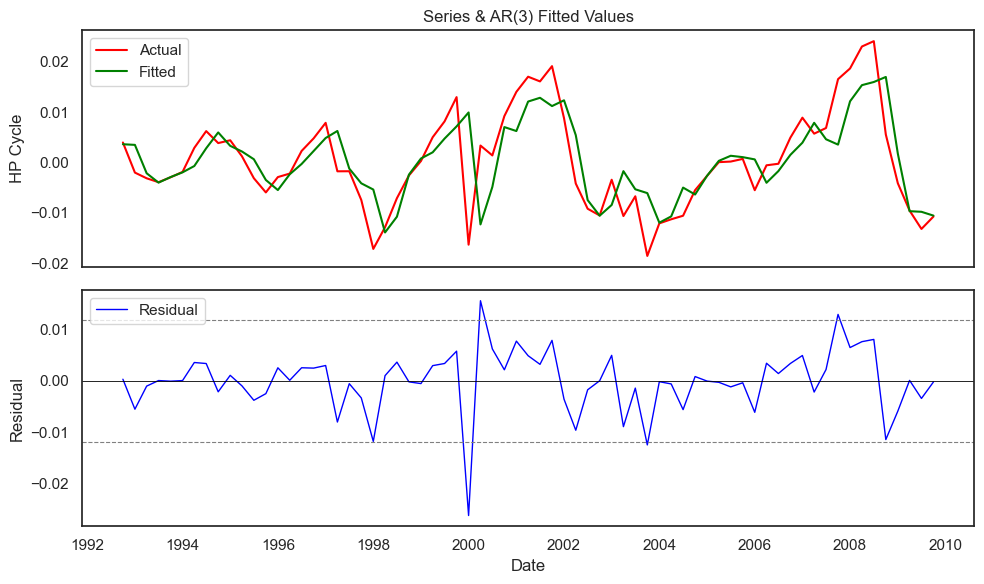

In [175]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# def run_ar_model(data, lags):
#     # Fit AR model with specified lags and a constant
#     model = AutoReg(data, lags=lags, trend='c', old_names=False)
#     results = model.fit()
    
#     # Print summary of the model
#     print(results.summary())
    
#     # Plot residuals via pandas (handles PeriodIndex)
#     plt.figure(figsize=(10, 6))
#     results.resid.plot(label='Residuals')
#     plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
#     plt.xlabel('Date')
#     plt.ylabel('Residuals')
#     plt.title(f'AR({lags}) Model Residuals')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

    # return results

# 3) Build AR(2) design matrix and estimate by OLS
X = pd.DataFrame({
    "const": 1.0,
    "y_lag1": data_q1.shift(1),
    "y_lag2": data_q1.shift(2),
    "y_lag3": data_q1.shift(3)
}).dropna()

y = data_q1.loc[X.index]

ols_res = sm.OLS(y, X).fit()

# 4) Extract fitted values & residuals
fitted = ols_res.fittedvalues
resid  = ols_res.resid

print(ols_res.summary())

# Compute residuals’ 95% “constant” CI: ±1.96·sd(resid)
resid_std = resid.std()
upper =  1.96 * resid_std
lower = -1.96 * resid_std

# Convert PeriodIndex to timestamps
t = y.index.to_timestamp()

# Two‐panel plot with residual CIs
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1, figsize=(10, 6), sharex=True,
    gridspec_kw={"height_ratios": [1, 1]}
)

# Top: Actual vs Fitted
ax_top.plot(t, y,      color="red",   label="Actual")
ax_top.plot(t, fitted, color="green", label="Fitted")
ax_top.set_ylabel("HP Cycle")
ax_top.legend(loc="upper left")
ax_top.set_title("Series & AR(3) Fitted Values")

# Bottom: Residuals + ±1.96·sd bands
ax_bot.plot(t, resid, color="blue", linewidth=1, label="Residual")
ax_bot.axhline(upper, color="gray", linestyle="--", linewidth=0.8)
ax_bot.axhline(lower, color="gray", linestyle="--", linewidth=0.8)
ax_bot.axhline(0,     color="black", linestyle="-", linewidth=0.6)
ax_bot.set_ylabel("Residual")
ax_bot.set_xlabel("Date")
ax_bot.legend(loc="upper left")

plt.tight_layout()
plt.savefig('AR3_fitted_residuals.png')
plt.show()


## ACF, PACF residual investigation

 lag ACF(resid) PACF(resid) ACF(resid²) PACF(resid²)
   1     -0.034      -0.034      0.253*       0.253*
   2      0.014       0.013       0.001       -0.067
   3      0.096       0.097      -0.026       -0.010
   4     -0.088      -0.083      -0.006        0.004
   5     -0.047      -0.056      -0.073       -0.080
   6      0.016       0.007      -0.045       -0.006
   7     -0.134      -0.117      -0.021       -0.012
   8      0.048       0.044       0.106        0.117
   9      0.055       0.054       0.077        0.020
  10     -0.098      -0.078      -0.092       -0.127
  11      0.032      -0.001      -0.015        0.051
  12    -0.302*     -0.326*      -0.018       -0.040
  13     -0.029      -0.018       0.000        0.026
  14     -0.149      -0.196      -0.052       -0.048
  15      0.012       0.072       0.079        0.106
  16     -0.169     -0.243*      -0.071       -0.147
  17      0.000      -0.049      -0.076       -0.044
  18      0.008      -0.065      -0.042       

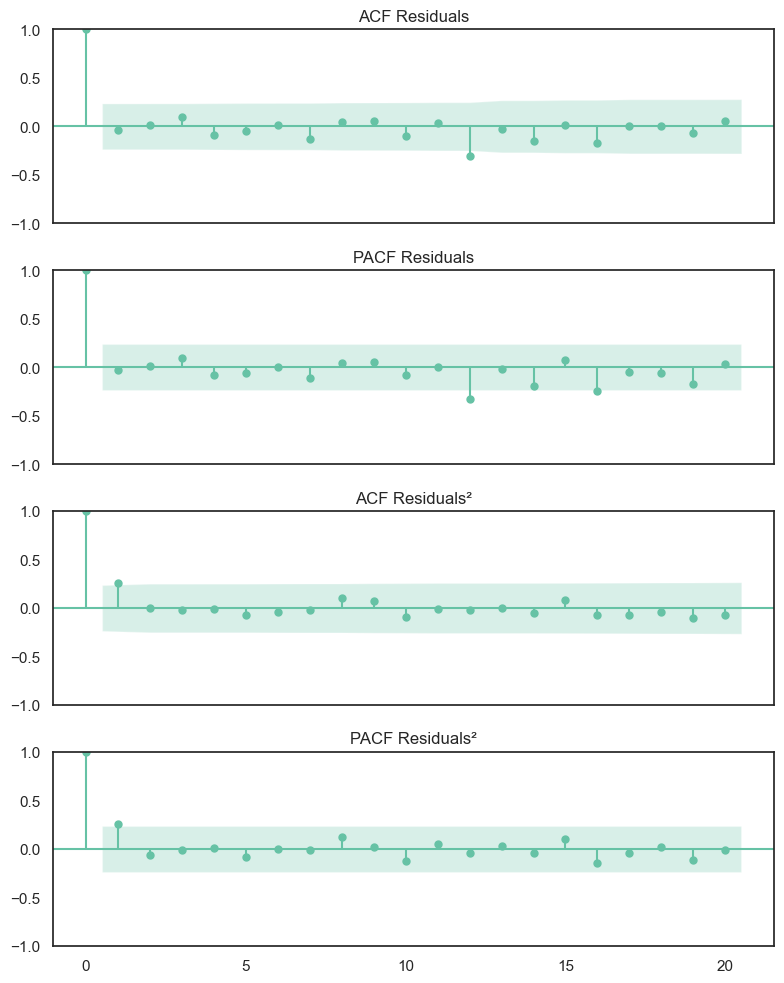

In [176]:
# prepare the two series
ts1 = resid
ts2 = resid**2

nlags = 20
T = len(ts1)
thresh = 1.96 / np.sqrt(T)

# compute ACF/PACF for both
acf1  = acf(ts1, nlags=nlags, fft=False, alpha=None)
pacf1 = pacf(ts1, nlags=nlags, method="ywmle", alpha=None)
acf2  = acf(ts2, nlags=nlags, fft=False, alpha=None)
pacf2 = pacf(ts2, nlags=nlags, method="ywmle", alpha=None)

# optional Ljung–Box if you want Q‐stats
# lb1 = acorr_ljungbox(ts1, lags=nlags, return_df=True)
# lb2 = acorr_ljungbox(ts2, lags=nlags, return_df=True)

# build table
rows = []
for k in range(1, nlags+1):
    a1 = acf1[k]
    p1 = pacf1[k]
    a2 = acf2[k]
    p2 = pacf2[k]
    rows.append({
        "lag":        k,
        "ACF(resid)":  f"{a1:.3f}{'*' if abs(a1)>thresh else ''}",
        "PACF(resid)":f"{p1:.3f}{'*' if abs(p1)>thresh else ''}",
        "ACF(resid²)":f"{a2:.3f}{'*' if abs(a2)>thresh else ''}",
        "PACF(resid²)":f"{p2:.3f}{'*' if abs(p2)>thresh else ''}",
    })

table = pd.DataFrame(rows)
print(table.to_string(index=False))

# optional: plot ACF/PACF for residuals (top) and squared residuals (bottom)
fig, axes = plt.subplots(4, 1, figsize=(8, 10), sharex=True)
sm.graphics.tsa.plot_acf(ts1, lags=nlags, ax=axes[0], title="ACF Residuals")
sm.graphics.tsa.plot_pacf(ts1, lags=nlags, ax=axes[1], title="PACF Residuals")
sm.graphics.tsa.plot_acf(ts2, lags=nlags, ax=axes[2], title="ACF Residuals²")
sm.graphics.tsa.plot_pacf(ts2, lags=nlags, ax=axes[3], title="PACF Residuals²")
plt.tight_layout()
plt.show()

## Normality Test of Residuals


Jarque Bera Statistic: 62.92700485097196
Jarque Bera p-value: 2.1655814129790384e-14
Jarque Bera Skewness: -1.0835998332118286
Jarque Bera Kurtosis: 7.146190958827249


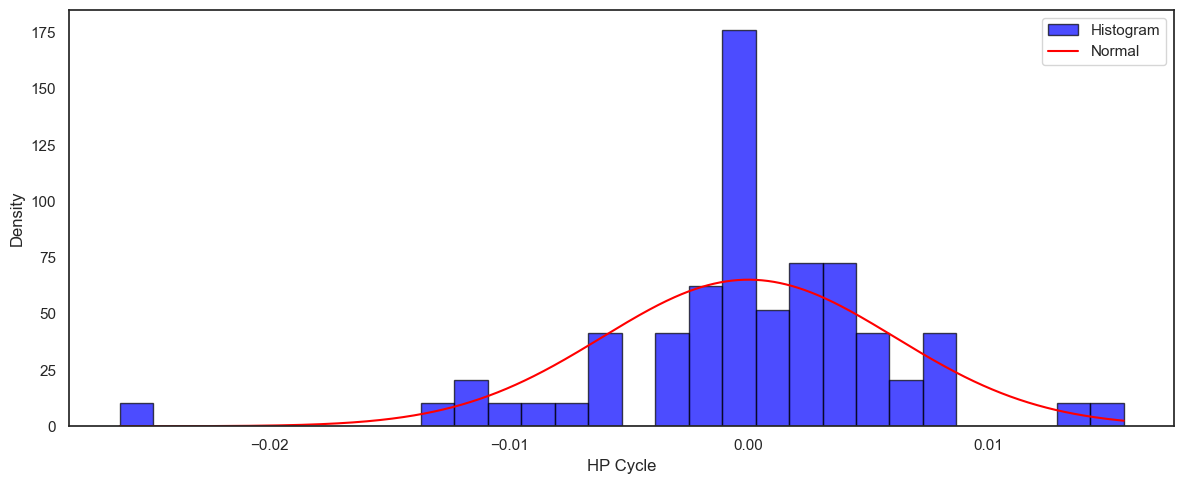

In [177]:
test_normality(resid)

# Question 3c)

## Sample plots 

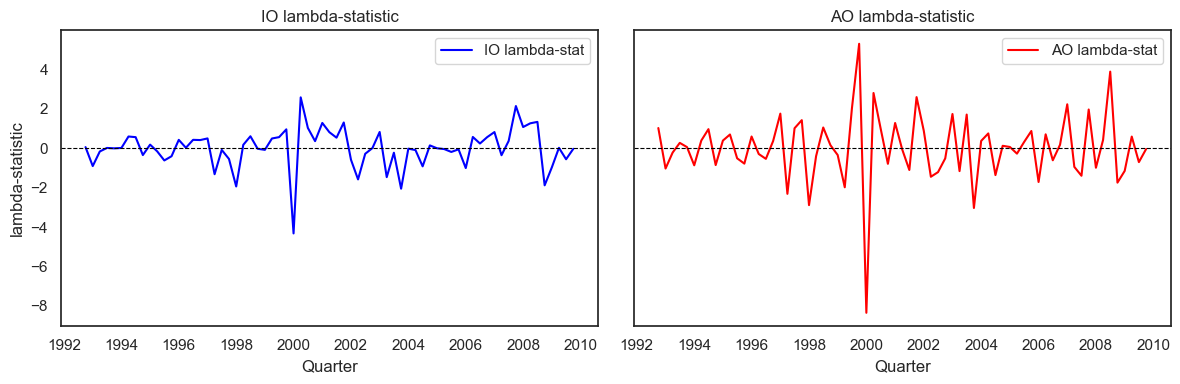

In [178]:
# code up the AI, AO statistics 
alpha_hat = ols_res.params['const']
phi_1 = ols_res.params['y_lag1']
phi_2 = ols_res.params['y_lag2']
phi_3 = ols_res.params['y_lag3']

AO_denom = np.std(resid) / np.sqrt(1+ phi_1**2 + phi_2**2 + phi_3**2)
IO_denom = np.std(resid)

AO_zeta = []
IO_zeta = []

for r in range(len(resid)):

    if r < len(resid) - 3:
        nominator_AO = resid[r] - phi_1 * resid[r+1] - phi_2 * resid[r+2] - phi_3 * resid[r+3]
        AO_zeta.append(nominator_AO)
    elif r < len(resid) - 2:
        nominator_AO = resid[r] - phi_1 * resid[r+1] - phi_2 * resid[r+2]
        AO_zeta.append(nominator_AO)
    elif r < len(resid) - 1:
        nominator_AO = resid[r] - phi_1 * resid[r+1]
        AO_zeta.append(nominator_AO)
    else:  
        nominator_AO = resid[r]
        AO_zeta.append(nominator_AO)

    nominator_IO = resid[r]
    IO_zeta.append(nominator_IO)

# normalize
IO_zeta = np.array(IO_zeta) / IO_denom
AO_zeta = np.array(AO_zeta) / AO_denom

# turn into Series with matching PeriodIndex
idx = resid.index
io_series = pd.Series(IO_zeta, index=idx)
ao_series = pd.Series(AO_zeta, index=idx)

# convert to timestamps for plotting
t = io_series.index.to_timestamp()

# 1x2 side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# IO ζ‐statistic
axes[0].plot(t, io_series, label='IO lambda-stat', color='blue')
axes[0].axhline(0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_title('IO lambda-statistic')
axes[0].set_xlabel('Quarter')
axes[0].set_ylabel('lambda-statistic')
axes[0].legend()

# AO ζ‐statistic
axes[1].plot(t, ao_series, label='AO lambda-stat', color='red')
axes[1].axhline(0, color='black', linestyle='--', linewidth=0.8)
axes[1].set_title('AO lambda-statistic')
axes[1].set_xlabel('Quarter')
axes[1].legend()

plt.tight_layout()
plt.savefig('outlier_stats.png')
plt.show()



In [179]:
# Combine into a DataFrame
zeta_df = pd.concat([io_series, ao_series], axis=1)

# Save to CSV
zeta_df.to_csv('zeta_output.csv')

# Optional: print the first few rows to verify
print(zeta_df.head())

                0         1
QUARTER                    
1992Q4   0.056577  1.023399
1993Q1  -0.905906 -1.030374
1993Q2  -0.164495 -0.222107
1993Q3   0.013993  0.270542
1993Q4  -0.006391  0.056577


## Simulate the Lambda distributions (H_0: AR(3) model with a constant)

In [180]:
import warnings
from tqdm import tqdm

# Silence FutureWarnings globally
warnings.filterwarnings("ignore", category=FutureWarning)

# number of simluations 
B = 100000
T = data_q1.shape[0]
sup_stats_AO = np.zeros(B)
sup_stats_IO = np.zeros(B)

for i in tqdm(range(B), desc="Simulating AR(3) null"):
    # create the simulated 'actual series'
    y_sample = np.zeros(T)

    # errors 
    epsilons =  np.random.normal(loc=0, scale=np.std(resid),size=T-3)

    for t in range(T): 
        if t < 3: 
           y_sample[t] = data_q1.iloc[t]
        else: 
            y_sample[t] = alpha_hat + phi_1 * y_sample[t-1] + phi_2 * y_sample[t-2] + phi_3 * y_sample[t-3] + epsilons[t-3]

    y_sim = pd.Series(y_sample, index=data_q1.index)   # convert to Series

    # now build your lagged DataFrame off of the Series:
    X_sim = pd.DataFrame({
        "const": 1.0,
        "y_lag1": y_sim.shift(1),
        "y_lag2": y_sim.shift(2),
        "y_lag3": y_sim.shift(3)
    }).dropna()
    
    # and adjust the dependent variable to match the same index:
    y_dep = y_sim.loc[X_sim.index]

    # then you can fit:
    ols_iter = sm.OLS(y_dep, X_sim).fit()

    # based on the model
    alpha_hati = ols_iter.params['const']
    phi_1i = ols_iter.params['y_lag1']
    phi_2i = ols_iter.params['y_lag2']
    phi_3i = ols_iter.params['y_lag3']
    residi = ols_iter.resid

    AO_denom = np.std(residi) / np.sqrt(1+ phi_1i**2 + phi_2i**2 + phi_3i**2)
    IO_denom = np.std(residi)

    AO_zeta = []
    IO_zeta = []

    
    for r in range(len(resid)):

        if r < len(residi) - 3:
            nominator_AO = residi[r] - phi_1i * residi[r+1] - phi_2i * residi[r+2] - phi_3i * residi[r+3]
            AO_zeta.append(nominator_AO)
        elif r < len(residi) - 2:
            nominator_AO = residi[r] - phi_1i * residi[r+1] - phi_2i * residi[r+2]
            AO_zeta.append(nominator_AO)
        elif r < len(residi) - 1:
            nominator_AO = residi[r] - phi_1i * residi[r+1]
            AO_zeta.append(nominator_AO)
        else:  
            nominator_AO = residi[r]
            AO_zeta.append(nominator_AO)

        nominator_IO = residi[r]
        IO_zeta.append(nominator_IO)

    # normalize
    IO_zeta = np.array(IO_zeta) / IO_denom
    AO_zeta = np.array(AO_zeta) / AO_denom

    sup_stats_AO[i] = np.max(np.abs(AO_zeta))
    sup_stats_IO[i] = np.max(np.abs(IO_zeta))

sim_results = pd.DataFrame({
    'sup_stats_AO': sup_stats_AO,
    'sup_stats_IO': sup_stats_IO
}, index=pd.RangeIndex(start=1, stop=B+1, name='simulation'))

sim_results.to_csv('simulation_MC.csv')


Simulating AR(3) null: 100%|██████████| 100000/100000 [06:02<00:00, 276.06it/s]


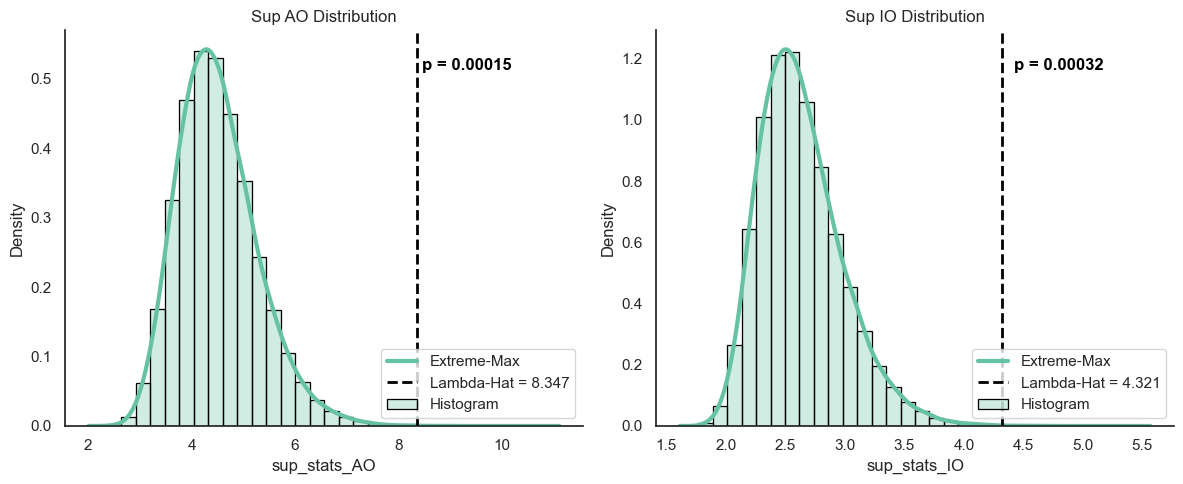

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns

p_AO = np.mean(sim_results['sup_stats_AO'] > np.max(np.abs(ao_series)))
p_IO = np.mean(sim_results['sup_stats_IO'] > np.max(np.abs(io_series)))

# 1) Use a white theme (no grid by default) and a nice color palette
sns.set_theme(style="white", palette="Set2")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 2) sup_stats_AO
sns.histplot(
    sim_results['sup_stats_AO'],
    bins=30,
    stat="density",
    ax=axes[0],
    edgecolor="k",
    alpha=0.3,
    legend=False,
    label = 'Histogram'
)
sns.kdeplot(
    sim_results['sup_stats_AO'],
    ax=axes[0],
    bw_adjust=1.5,    # larger→fatter
    linewidth=3,      # thicker line
    label="Extreme-Max"
)
axes[0].axvline(np.max(np.abs(ao_series)), color="black", linestyle="--", linewidth=2, label=f"Lambda-Hat = {round(np.max(np.abs(ao_series)),3)}")

ymax = axes[0].get_ylim()[1]
axes[0].text(
    np.max(np.abs(ao_series)) + 0.1,      # x-position, a bit to the right of the line
    ymax * 0.9,           # y-position, 90% up the axis
    f"p = {p_AO:.5f}",
    fontsize=12,
    fontweight="bold",
    color="black"
)

axes[0].set_title("Sup AO Distribution")
axes[0].set_xlabel("sup_stats_AO")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(False)  # just in case any grid remains
sns.despine(ax=axes[0])

# 3) sup_stats_IO
sns.histplot(
    sim_results['sup_stats_IO'],
    bins=30,
    stat="density",
    ax=axes[1],
    edgecolor="k",
    alpha=0.3,
    legend=False,
    label = 'Histogram'
)
sns.kdeplot(
    sim_results['sup_stats_IO'],
    ax=axes[1],
    bw_adjust=1.5,
    linewidth=3,
    label="Extreme-Max"
)
axes[1].axvline(np.max(np.abs(io_series)), color="black", linestyle="--", linewidth=2, label=f"Lambda-Hat = {round(np.max(np.abs(io_series)),3)}")

# annotate p‐value
ymax = axes[1].get_ylim()[1]
axes[1].text(
    np.max(np.abs(io_series)) + 0.1,
    ymax * 0.9,
    f"p = {p_IO:.5f}",
    fontsize=12,
    fontweight="bold",
    color="black"
)

axes[1].set_title("Sup IO Distribution")
axes[1].set_xlabel("sup_stats_IO")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].grid(False)
sns.despine(ax=axes[1])

plt.tight_layout()
plt.savefig('distribution_new_runs.png')
plt.show()


# Question 3d) 
### One output is below (read the markdowns)

## AR(3) model with AO treatment for 2000Q1

/opt/anaconda3/envs/test/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                HPCYCLE   No. Observations:                   72
Model:               SARIMAX(3, 0, 0)   Log Likelihood                 271.134
Date:                Tue, 17 Jun 2025   AIC                           -530.268
Time:                        23:42:35   BIC                           -516.864
Sample:                    03-31-1992   HQIC                          -524.950
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.001      0.198      0.843      -0.001       0.002
d_2000Q1      -0.0237      0.004     -5.281      0.000      -0.033      -0.015
ar.L1          1.0146      0.128      7.904      0.0

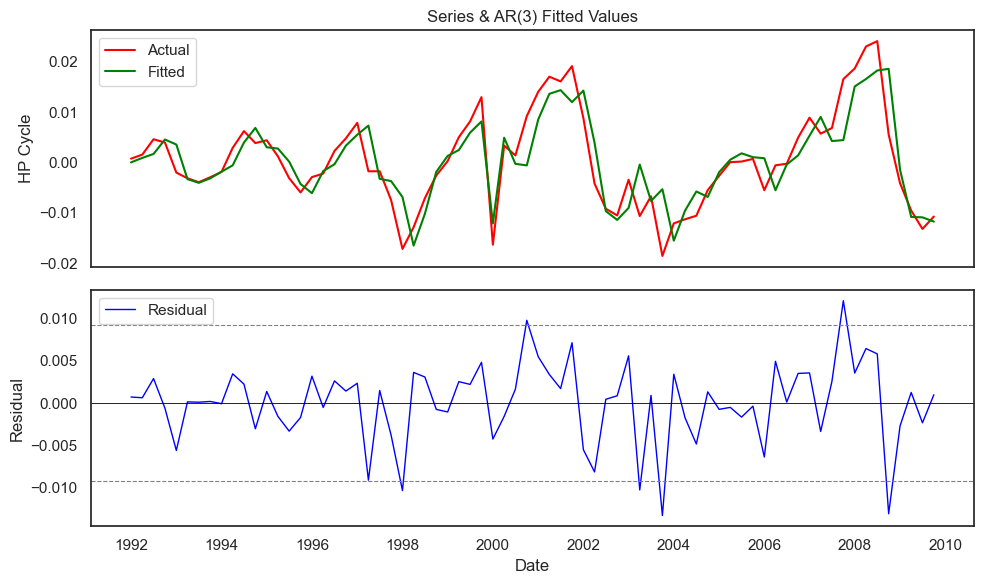

In [182]:
df_raw = pd.read_excel("RSGCS.xlsx")

date_col = df_raw.columns[0]
df_raw[date_col] = pd.PeriodIndex(df_raw[date_col].astype(str), freq='Q')

df_raw = df_raw.set_index(date_col)

y_all = df_raw['HPCYCLE']         

# Trim to sample 1992Q1‒2009Q4
y_all = y_all.loc['1992Q1':'2009Q4']

dummy_full = (y_all.index == pd.Period('2000Q1')).astype(int)
dummy_full = pd.Series(dummy_full, index=y_all.index, name='d_2000Q1')

# choose the same sub-sample the slide hinted at (1999Q4‒2009Q4)
y_ao   = y_all.loc['1992Q1':'2009Q4']
exog_ao = dummy_full.loc[y_ao.index]

mod_ao  = sm.tsa.SARIMAX(
        endog=y_ao,
        exog=exog_ao,
        order=(3,0,0),
        trend='c',
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
ols_res_o  = mod_ao.fit(disp=False)

# 4) Extract fitted values & residuals
fitted_o = ols_res_o.fittedvalues
resid_o  = ols_res_o.resid

print(ols_res_o.summary())

# Compute residuals’ 95% “constant” CI: ±1.96·sd(resid)
resid_std_o = resid_o.std()
upper_o =  1.96 * resid_std_o
lower_o = -1.96 * resid_std_o

# Convert PeriodIndex to timestamps
t = y_ao.index.to_timestamp()

# Two‐panel plot with residual CIs
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1, figsize=(10, 6), sharex=True,
    gridspec_kw={"height_ratios": [1, 1]}
)

# Top: Actual vs Fitted
ax_top.plot(t, y_ao,      color="red",   label="Actual")
ax_top.plot(t, fitted_o, color="green", label="Fitted")
ax_top.set_ylabel("HP Cycle")
ax_top.legend(loc="upper left")
ax_top.set_title("Series & AR(3) Fitted Values")

# Bottom: Residuals + ±1.96·sd bands
ax_bot.plot(t, resid_o, color="blue", linewidth=1, label="Residual")
ax_bot.axhline(upper_o, color="gray", linestyle="--", linewidth=0.8)
ax_bot.axhline(lower_o, color="gray", linestyle="--", linewidth=0.8)
ax_bot.axhline(0,     color="black", linestyle="-", linewidth=0.6)
ax_bot.set_ylabel("Residual")
ax_bot.set_xlabel("Date")
ax_bot.legend(loc="upper left")

plt.tight_layout()
plt.savefig('AR3_fitted_residuals.png')
plt.show()


 lag ACF(resid) PACF(resid) ACF(resid²) PACF(resid²)
   1      0.007       0.007      -0.037       -0.037
   2      0.024       0.024       0.098        0.097
   3      0.021       0.021       0.035        0.043
   4     -0.065      -0.066       0.135        0.130
   5     -0.048      -0.048      -0.094       -0.093
   6      0.053       0.057       0.047        0.014
   7     -0.026      -0.022      -0.065       -0.060
   8     -0.066      -0.072      -0.079       -0.101
   9      0.152       0.148      -0.031       -0.005
  10     -0.183      -0.184       0.034        0.040
  11     -0.041      -0.039       0.044        0.086
  12     -0.227     -0.249*       0.040        0.057
  13     -0.003       0.038      -0.120       -0.146
  14     -0.114      -0.131      -0.093       -0.141
  15     -0.118      -0.161      -0.026       -0.046
  16     -0.172      -0.221       0.146        0.183
  17      0.072       0.081      -0.046        0.045
  18     -0.104      -0.207       0.050       

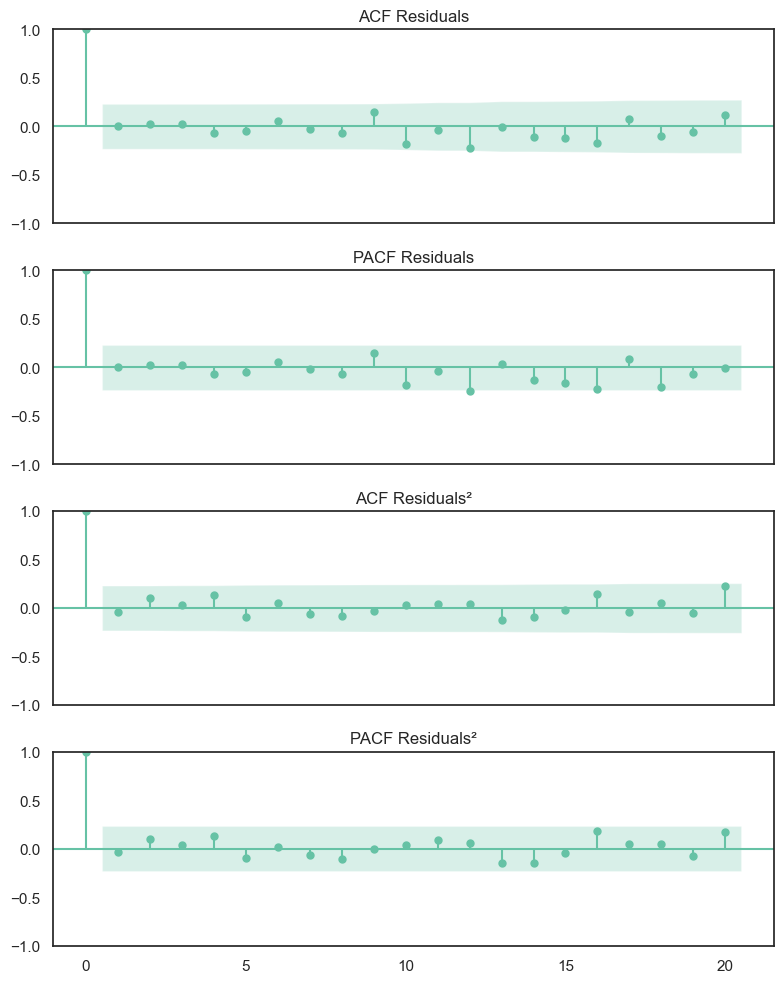

In [183]:
# prepare the two series
ts1 = resid_o
ts2 = resid_o**2

nlags = 20
T = len(ts1)
thresh = 1.96 / np.sqrt(T)

# compute ACF/PACF for both
acf1  = acf(ts1, nlags=nlags, fft=False, alpha=None)
pacf1 = pacf(ts1, nlags=nlags, method="ywmle", alpha=None)
acf2  = acf(ts2, nlags=nlags, fft=False, alpha=None)
pacf2 = pacf(ts2, nlags=nlags, method="ywmle", alpha=None)

# optional Ljung–Box if you want Q‐stats
# lb1 = acorr_ljungbox(ts1, lags=nlags, return_df=True)
# lb2 = acorr_ljungbox(ts2, lags=nlags, return_df=True)

# build table
rows = []
for k in range(1, nlags+1):
    a1 = acf1[k]
    p1 = pacf1[k]
    a2 = acf2[k]
    p2 = pacf2[k]
    rows.append({
        "lag":        k,
        "ACF(resid)":  f"{a1:.3f}{'*' if abs(a1)>thresh else ''}",
        "PACF(resid)":f"{p1:.3f}{'*' if abs(p1)>thresh else ''}",
        "ACF(resid²)":f"{a2:.3f}{'*' if abs(a2)>thresh else ''}",
        "PACF(resid²)":f"{p2:.3f}{'*' if abs(p2)>thresh else ''}",
    })

table = pd.DataFrame(rows)
print(table.to_string(index=False))

# optional: plot ACF/PACF for residuals (top) and squared residuals (bottom)
fig, axes = plt.subplots(4, 1, figsize=(8, 10), sharex=True)
sm.graphics.tsa.plot_acf(ts1, lags=nlags, ax=axes[0], title="ACF Residuals")
sm.graphics.tsa.plot_pacf(ts1, lags=nlags, ax=axes[1], title="PACF Residuals")
sm.graphics.tsa.plot_acf(ts2, lags=nlags, ax=axes[2], title="ACF Residuals²")
sm.graphics.tsa.plot_pacf(ts2, lags=nlags, ax=axes[3], title="PACF Residuals²")
plt.tight_layout()
plt.show()

Jarque Bera Statistic: 8.48637556626986
Jarque Bera p-value: 0.014361736691790455
Jarque Bera Skewness: -0.6378463822768874
Jarque Bera Kurtosis: 4.096083858967202


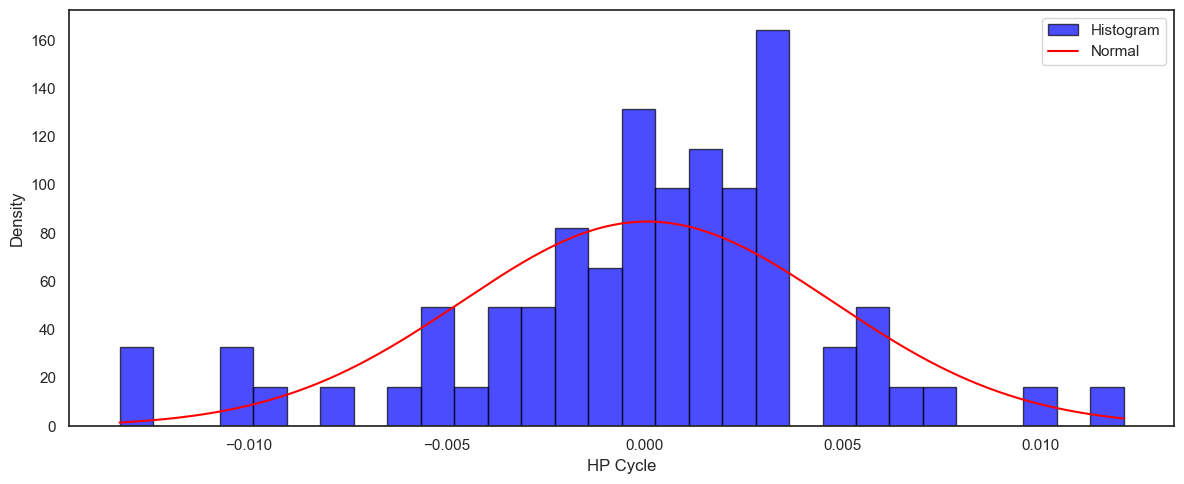

In [184]:
test_normality(resid_o)

## lambda plot

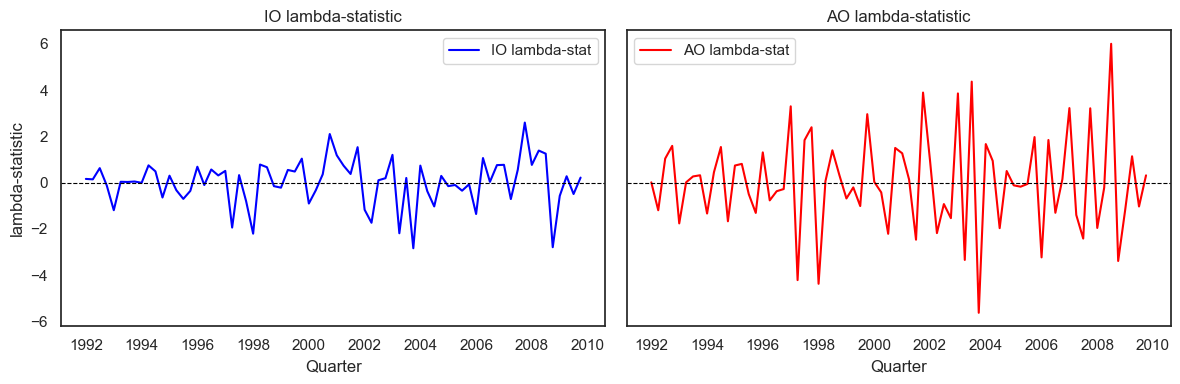

In [185]:
# code up the AI, AO statistics 
alpha_hat_o = ols_res_o.params['intercept']
phi_1_o = ols_res_o.params['ar.L1']
phi_2_o = ols_res_o.params['ar.L2']
phi_3_o = ols_res_o.params['ar.L3']
delta_o = ols_res_o.params['d_2000Q1']

AO_denom = np.std(resid_o) / np.sqrt(1+ phi_1_o**2 + phi_2_o**2 + phi_3_o**2)
IO_denom = np.std(resid_o)

AO_zeta = []
IO_zeta = []

for r in range(len(resid_o)):

    if r < len(resid_o) - 3:
        nominator_AO = resid_o[r] - phi_1_o * resid_o[r+1] - phi_2_o * resid_o[r+2] - phi_3_o * resid_o[r+3]
        AO_zeta.append(nominator_AO)
    elif r < len(resid_o) - 2:
        nominator_AO = resid_o[r] - phi_1_o * resid_o[r+1] - phi_2_o * resid_o[r+2]
        AO_zeta.append(nominator_AO)
    elif r < len(resid_o) - 1:
        nominator_AO = resid_o[r] - phi_1_o * resid_o[r+1]
        AO_zeta.append(nominator_AO)
    else:  
        nominator_AO = resid_o[r]
        AO_zeta.append(nominator_AO)

    nominator_IO = resid_o[r]
    IO_zeta.append(nominator_IO)

# normalize
IO_zeta = np.array(IO_zeta) / IO_denom
AO_zeta = np.array(AO_zeta) / AO_denom

# turn into Series with matching PeriodIndex
idx = resid_o.index
io_series = pd.Series(IO_zeta, index=idx)
ao_series = pd.Series(AO_zeta, index=idx)

# convert to timestamps for plotting
t = io_series.index.to_timestamp()

# 1x2 side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# IO ζ‐statistic
axes[0].plot(t, io_series, label='IO lambda-stat', color='blue')
axes[0].axhline(0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_title('IO lambda-statistic')
axes[0].set_xlabel('Quarter')
axes[0].set_ylabel('lambda-statistic')
axes[0].legend()

# AO ζ‐statistic
axes[1].plot(t, ao_series, label='AO lambda-stat', color='red')
axes[1].axhline(0, color='black', linestyle='--', linewidth=0.8)
axes[1].set_title('AO lambda-statistic')
axes[1].set_xlabel('Quarter')
axes[1].legend()

plt.tight_layout()
plt.savefig('outlier_stats.png')
plt.show()


In [186]:
# import warnings
# from tqdm import tqdm

# # Silence FutureWarnings globally
# warnings.filterwarnings("ignore", category=FutureWarning)

# # number of simluations 
# B = 1000
# T = data_q1.shape[0]
# sup_stats_AO = np.zeros(B)
# sup_stats_IO = np.zeros(B)

# # dummy 
# series_ = np.asarray(data_q1.index == pd.Period("2000Q1"), dtype=int)


# for i in tqdm(range(B), desc="Simulating AR(3) null with the 2000Q1 dummy"):
#     # create the simulated 'actual series'
#     y_sample = np.zeros(T)

#     # errors 
#     epsilons =  np.random.normal(loc=0, scale=np.std(resid),size=T-3)


#     for t in range(T): 
#         if t < 3: 
#            y_sample[t] = data_q1.iloc[t]
#         else: 
#             y_sample[t] = alpha_hat_o + phi_1_o * y_sample[t-1] + phi_2_o * y_sample[t-2] + phi_3_o * y_sample[t-3] + delta_o * series_[t] - phi_1_o * delta_o * series_[t-1] - phi_2_o * delta_o * series_[t-2] - phi_3_o * delta_o * series_[t-3] + epsilons[t-3]

#     y_sim = pd.Series(y_sample, index=data_q1.index)   # convert to Series

#     # now build your lagged DataFrame off of the Series:
#     mod_ao  = sm.tsa.SARIMAX(
#         endog=y_sim,
#         exog=series_,
#         order=(3,0,0),
#         trend='c',
#         enforce_stationarity=False,
#         enforce_invertibility=False,
#     )
#     ols_iter   = mod_ao.fit(disp=False)

#     # based on the model
#     alpha_hati = ols_iter.params['intercept']
#     phi_1i = ols_iter.params['ar.L1']
#     phi_2i = ols_iter.params['ar.L2']
#     phi_3i = ols_iter.params['ar.L3']
#     # residi = ols_iter.resid

#     AO_denom = np.std(residi) / np.sqrt(1+ phi_1i**2 + phi_2i**2 + phi_3i**2)
#     IO_denom = np.std(residi)

#     AO_zeta = []
#     IO_zeta = []

    
#     for r in range(len(resid)):

#         if r < len(resid) - 3:
#             nominator_AO = residi[r] - phi_1i * residi[r+1] - phi_2i * residi[r+2] - phi_3i * residi[r+3]
#             AO_zeta.append(nominator_AO)
#         elif r < len(resid) - 2:
#             nominator_AO = residi[r] - phi_1i * residi[r+1] - phi_2i * residi[r+2]
#             AO_zeta.append(nominator_AO)
#         elif r < len(resid) - 1:
#             nominator_AO = residi[r] - phi_1i * residi[r+1]
#             AO_zeta.append(nominator_AO)
#         else:  
#             nominator_AO = residi[r]
#             AO_zeta.append(nominator_AO)

#         nominator_IO = residi[r]
#         IO_zeta.append(nominator_IO)

#     # normalize
#     IO_zeta = np.array(IO_zeta) / IO_denom
#     AO_zeta = np.array(AO_zeta) / AO_denom

#     sup_stats_AO[i] = np.max(np.abs(AO_zeta))
#     sup_stats_IO[i] = np.max(np.abs(IO_zeta))

# sim_results = pd.DataFrame({
#     'sup_stats_AO': sup_stats_AO,
#     'sup_stats_IO': sup_stats_IO
# }, index=pd.RangeIndex(start=1, stop=B+1, name='simulation'))

# sim_results.to_csv('simulation_MC_o.csv')


In [187]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# sim_results = pd.read_csv('simulation_MC_o.csv')

# p_AO = np.mean(sim_results['sup_stats_AO'] > np.max(np.abs(ao_series)))
# p_IO = np.mean(sim_results['sup_stats_IO'] > np.max(np.abs(io_series)))

# # 1) Use a white theme (no grid by default) and a nice color palette
# sns.set_theme(style="white", palette="Set2")

# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# # 2) sup_stats_AO
# sns.histplot(
#     sim_results['sup_stats_AO'],
#     bins=30,
#     stat="density",
#     ax=axes[0],
#     edgecolor="k",
#     alpha=0.3,
#     legend=False,
#     label = 'Histogram'
# )
# sns.kdeplot(
#     sim_results['sup_stats_AO'],
#     ax=axes[0],
#     bw_adjust=1.5,    # larger→fatter
#     linewidth=3,      # thicker line
#     label="Extreme-Max"
# )
# axes[0].axvline(np.max(np.abs(ao_series)), color="black", linestyle="--", linewidth=2, label=f"Lambda-Hat = {round(np.max(np.abs(ao_series)),3)}")

# ymax = axes[0].get_ylim()[1]
# axes[0].text(
#     np.max(np.abs(ao_series)) + 0.1,      # x-position, a bit to the right of the line
#     ymax * 0.9,           # y-position, 90% up the axis
#     f"p = {p_AO:.5f}",
#     fontsize=12,
#     fontweight="bold",
#     color="black"
# )

# axes[0].set_title("Sup AO Distribution")
# axes[0].set_xlabel("sup_stats_AO")
# axes[0].set_ylabel("Density")
# axes[0].legend()
# axes[0].grid(False)  # just in case any grid remains
# sns.despine(ax=axes[0])

# # 3) sup_stats_IO
# sns.histplot(
#     sim_results['sup_stats_IO'],
#     bins=30,
#     stat="density",
#     ax=axes[1],
#     edgecolor="k",
#     alpha=0.3,
#     legend=False,
#     label = 'Histogram'
# )
# sns.kdeplot(
#     sim_results['sup_stats_IO'],
#     ax=axes[1],
#     bw_adjust=1.5,
#     linewidth=3,
#     label="Extreme-Max"
# )
# axes[1].axvline(np.max(np.abs(io_series)), color="black", linestyle="--", linewidth=2, label=f"Lambda-Hat = {round(np.max(np.abs(io_series)),3)}")

# # annotate p‐value
# ymax = axes[1].get_ylim()[1]
# axes[1].text(
#     np.max(np.abs(io_series)) + 0.1,
#     ymax * 0.9,
#     f"p = {p_IO:.5f}",
#     fontsize=12,
#     fontweight="bold",
#     color="black"
# )

# axes[1].set_title("Sup IO Distribution")
# axes[1].set_xlabel("sup_stats_IO")
# axes[1].set_ylabel("Density")
# axes[1].legend()
# axes[1].grid(False)
# sns.despine(ax=axes[1])

# plt.tight_layout()
# plt.savefig('distribution_o.png')
# plt.show()


# FIRST FIGURE 3D !!!!! (Mattie Boy)

                               SARIMAX Results                                
Dep. Variable:                HPCYCLE   No. Observations:                   72
Model:               SARIMAX(3, 0, 0)   Log Likelihood                 271.134
Date:                Tue, 17 Jun 2025   AIC                           -530.268
Time:                        23:42:37   BIC                           -516.864
Sample:                    03-31-1992   HQIC                          -524.950
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.001      0.198      0.843      -0.001       0.002
d_2000Q1      -0.0237      0.004     -5.281      0.000      -0.033      -0.015
ar.L1          1.0146      0.128      7.904      0.0

/opt/anaconda3/envs/test/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


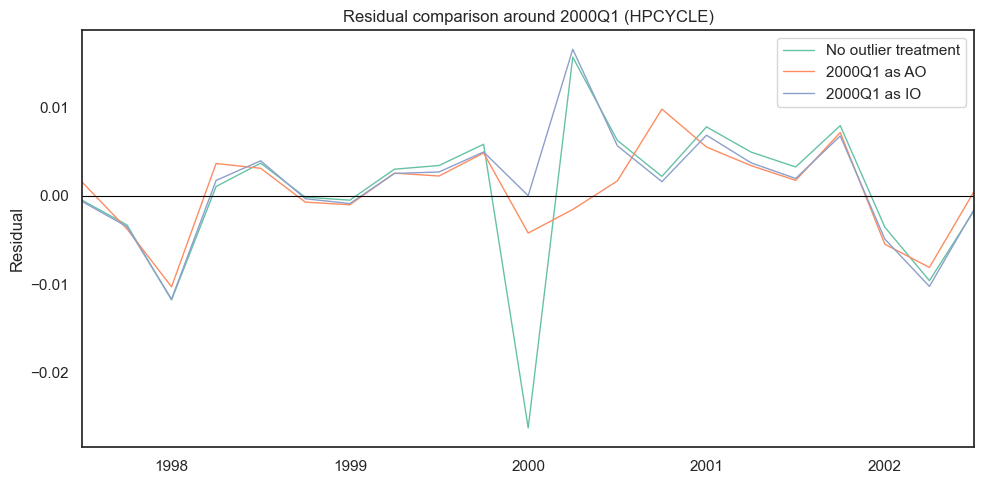

In [188]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------------------------------------------
# 1.  READ THE DATA  – use the uploaded Excel in /mnt/data
# ------------------------------------------------------------------
FILE = Path("RSGCS.xlsx")          # path ChatGPT can see
sheet = 0                                    # change if necessary

df_raw = pd.read_excel(FILE, sheet_name=sheet)

# ----  make a quarterly PeriodIndex  --------------------------------
# assume the first column contains strings like '1992Q1', '1992Q2', …
# If your file stores dates differently, adjust this parsing block.
date_col = df_raw.columns[0]
df_raw[date_col] = pd.PeriodIndex(df_raw[date_col].astype(str), freq='Q')

df_raw = df_raw.set_index(date_col)
# ------------------------------------------------------------------
# 2.  WE ONLY NEED THE LAST COLUMN ― 'HPCYCLE'
# ------------------------------------------------------------------
y_all = df_raw['HPCYCLE']          # raises KeyError if the name is wrong

# Trim to sample 1992Q1‒2009Q4
y_all = y_all.loc['1992Q1':'2009Q4']

# ------------------------------------------------------------------
# 3.  AR(3) WITHOUT OUTLIER TREATMENT
# ------------------------------------------------------------------
X_no = pd.DataFrame({
    'const' : 1.0,
    'lag1'  : y_all.shift(1),
    'lag2'  : y_all.shift(2),
    'lag3'  : y_all.shift(3)
}).dropna()

y_no = y_all.loc[X_no.index]

ols_no = sm.OLS(y_no, X_no).fit()
resid_no = ols_no.resid

# ------------------------------------------------------------------
# 4.  2000Q1 AS **IO**  (dummy goes into X)
# ------------------------------------------------------------------
X_io = X_no.copy()
X_io['d_2000Q1'] = (X_io.index == pd.Period('2000Q1')).astype(int)
y_io = y_all.loc[X_io.index]

ols_io = sm.OLS(y_io, X_io).fit()
resid_io = ols_io.resid

# ------------------------------------------------------------------
# 5.  2000Q1 AS **AO**  (dummy goes into EXOG of SARIMAX)
# ------------------------------------------------------------------
dummy_full = (y_all.index == pd.Period('2000Q1')).astype(int)
dummy_full = pd.Series(dummy_full, index=y_all.index, name='d_2000Q1')

# choose the same sub-sample the slide hinted at (1999Q4‒2009Q4)
y_ao   = y_all.loc['1992Q1':'2009Q4']
exog_ao = dummy_full.loc[y_ao.index]

mod_ao  = sm.tsa.SARIMAX(
    endog=y_ao,
    exog=exog_ao,
    order=(3,0,0),
    trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False,
)
res_ao   = mod_ao.fit(disp=False)
resid_ao = res_ao.resid

print(res_ao.summary())

# ------------------------------------------------------------------
# 6.  PLOT THE THREE RESIDUAL SERIES (±10 quarters around 2000Q1)
# ------------------------------------------------------------------
resid_df = pd.DataFrame({
    'No outlier treatment': resid_no,
    '2000Q1 as AO'        : resid_ao,
    '2000Q1 as IO'        : resid_io
}).dropna()

centre = pd.Period('2000Q1')
window = resid_df.loc[centre-10 : centre+10]   # ±10 quarters

fig, ax = plt.subplots(figsize=(10, 5))
window.plot(ax=ax, linewidth=1)

ax.axhline(0, color='k', linewidth=0.8)
ax.set_title('Residual comparison around 2000Q1 (HPCYCLE)')
ax.set_xlabel('')
ax.set_ylabel('Residual')
plt.tight_layout()
plt.show()


# Question 3e

# COVID Period

## Model comparison and OLS PRINTS 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   69
Model:               SARIMAX(3, 0, 0)   Log Likelihood                 242.123
Date:                Tue, 17 Jun 2025   AIC                           -474.246
Time:                        23:42:37   BIC                           -463.298
Sample:                    12-31-1992   HQIC                          -469.920
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.001      0.133      0.894      -0.002       0.002
ar.L1          0.7565      0.095      7.957      0.000       0.570       0.943
ar.L2          0.2100      0.142      1.475      0.1

/opt/anaconda3/envs/test/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


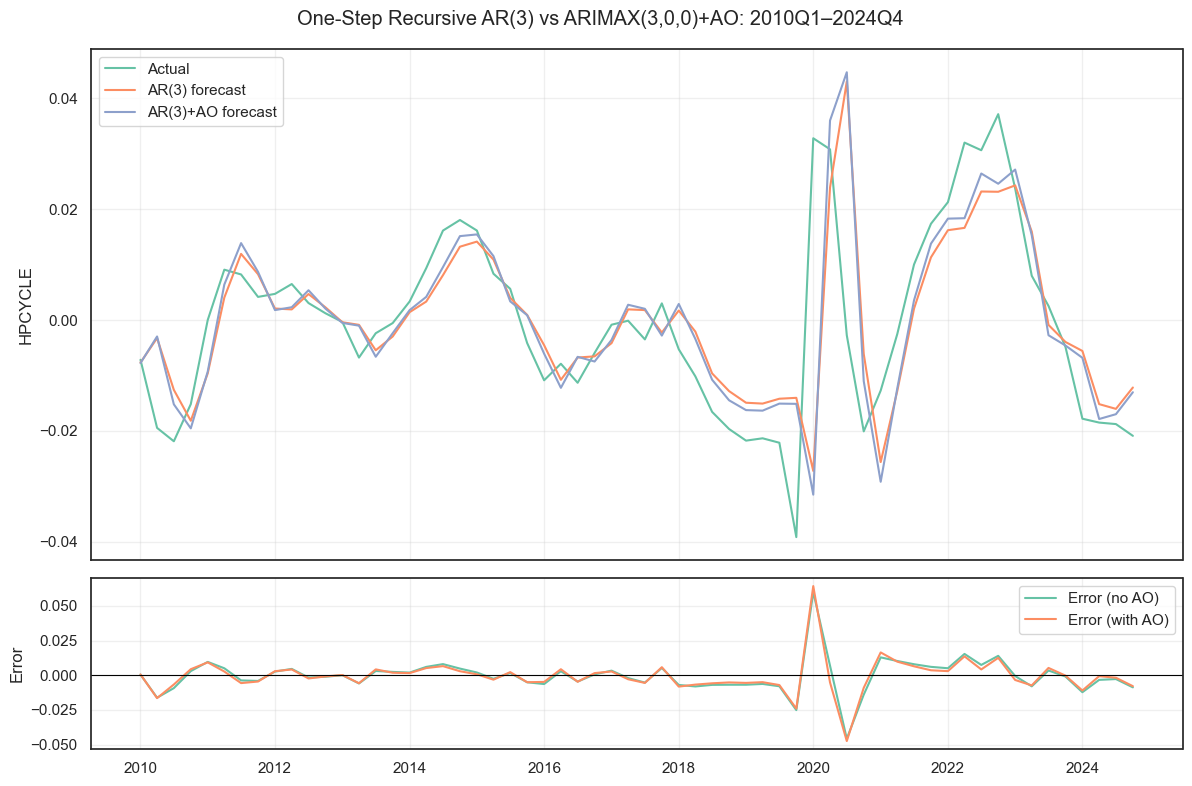

In [189]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ------------------------------------------------------------------
# 1│  READ THE DATA
# ------------------------------------------------------------------
FILE   = Path("RSGCS.xlsx")  # Excel file path
SHEET  = 0                     # sheet index/name
SERIES = "HPCYCLE"           # series column

raw = pd.read_excel(FILE, sheet_name=SHEET)
raw.iloc[:, 0] = pd.PeriodIndex(raw.iloc[:, 0].astype(str), freq="Q")
raw = raw.set_index(raw.columns[0]).sort_index()
y = raw[SERIES].astype(float)

# ------------------------------------------------------------------
# 2│  BUILD LAGS AND AO DUMMY
# ------------------------------------------------------------------
lagged = pd.concat([
    y.shift(i).rename(f"lag{i}") for i in range(1, 4)
], axis=1)
# Create AO dummy as a Series, not a numpy array
date_ao = pd.Period("2000Q1", freq="Q")
dummy_ao = pd.Series((y.index == date_ao).astype(int),
                     index=y.index, name="AO")

data = pd.concat([y.rename("y"), lagged, dummy_ao], axis=1).dropna()

# ------------------------------------------------------------------
# 3│  TRAIN / TEST SPLIT
# ------------------------------------------------------------------
train = data.loc[:"2009Q4"]
test  = data.loc["2010Q1":"2024Q4"]

# ------------------------------------------------------------------
# 4│  FIT AR(3) WITHOUT AO (SARIMAX)
# ------------------------------------------------------------------
mod_no = sm.tsa.SARIMAX(
    endog=train["y"],
    order=(3,0,0), trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_no = mod_no.fit(disp=False)
print(res_no.summary())
params_no = res_no.params  # contains const, ar.L1, ar.L2, ar.L3

# ------------------------------------------------------------------
# 5│  RECURSIVE ONE-STEP FORECASTS (NO AO)
# ------------------------------------------------------------------
y_hist = train["y"].tolist()
fc_no = []
for t in range(len(test)):
    y1, y2, y3 = y_hist[-1], y_hist[-2], y_hist[-3]
    f = (params_no['intercept']
         + params_no['ar.L1'] * y1
         + params_no['ar.L2'] * y2
         + params_no['ar.L3'] * y3)
    fc_no.append(f)
    # update history with actual
    y_hist.append(test['y'].iloc[t])
fc_no = pd.Series(fc_no, index=test.index)

# ------------------------------------------------------------------
# 6│  FIT ARIMAX WITH AO (SARIMAX + EXOG)
# ------------------------------------------------------------------
mod_ao = sm.tsa.SARIMAX(
    endog=train["y"],
    exog=train[["AO"]],
    order=(3,0,0), trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_ao = mod_ao.fit(disp=False)
print(res_ao.summary())
params_ao = res_ao.params  # contains const, ar.*, exog.AO

# ------------------------------------------------------------------
# 7│  RECURSIVE ONE-STEP FORECASTS (WITH AO)
# ------------------------------------------------------------------
y_hist = train["y"].tolist()
fc_ao = []
for t in range(len(test)):
    y1, y2, y3 = y_hist[-1], y_hist[-2], y_hist[-3]
    # AO dummy = 0 in forecast period
    ao = 0
    f = (params_ao['intercept']
         + params_ao['ar.L1'] * y1
         + params_ao['ar.L2'] * y2
         + params_ao['ar.L3'] * y3
         + params_ao['AO'] * ao)
    fc_ao.append(f)
    y_hist.append(test['y'].iloc[t])
fc_ao = pd.Series(fc_ao, index=test.index)

# ------------------------------------------------------------------
# 8│  COMPUTE FORECAST ERRORS
# ------------------------------------------------------------------
err_no = test['y'] - fc_no
err_ao = test['y'] - fc_ao

# ------------------------------------------------------------------
# 9│  PLOT RESULTS
# ------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True,
                                gridspec_kw={"height_ratios": [3, 1]})

# top: actual vs forecasts
ax1.plot(test.index.to_timestamp(), test['y'], label='Actual')
ax1.plot(fc_no.index.to_timestamp(), fc_no, label='AR(3) forecast')
ax1.plot(fc_ao.index.to_timestamp(), fc_ao, label='AR(3)+AO forecast')
ax1.set_ylabel(SERIES)
ax1.legend()
ax1.grid('--', alpha=0.3)

# bottom: errors
ax2.plot(err_no.index.to_timestamp(), err_no, label='Error (no AO)')
ax2.plot(err_ao.index.to_timestamp(), err_ao, label='Error (with AO)')
ax2.axhline(0, color='k', lw=0.8)
ax2.set_ylabel('Error')
ax2.legend()
ax2.grid('--', alpha=0.3)

fig.suptitle('One-Step Recursive AR(3) vs ARIMAX(3,0,0)+AO: 2010Q1–2024Q4')
plt.tight_layout()
plt.show()

pred_errors_no = test['y'] - fc_no
pred_errors_ao = test['y'] - fc_ao


### MSPE Errors

(283.53869040681224, 2.693739999080503e-62, 1.0246920955873882, 13.450622019750202)


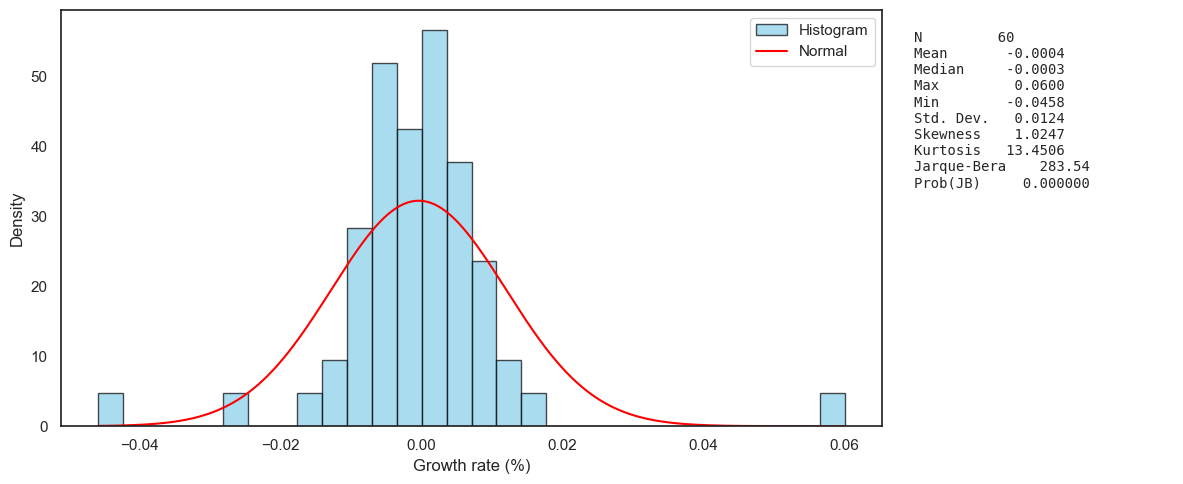

In [190]:
def test_normality(growthRate):
    mean = growthRate.mean()
    median = growthRate.median()
    mn, mx = growthRate.min(), growthRate.max()
    std = growthRate.std()
    skew = growthRate.skew()
    kurt = growthRate.kurtosis()
    jb_stat, jb_pvalue, jb_skew, jb_kurt = jarque_bera(growthRate)

    print(jarque_bera(growthRate))

    fig, (ax_hist, ax_stats) = plt.subplots(1, 2, figsize=(12, 5),
                                            gridspec_kw={'width_ratios': [3, 1]})

    count, bins, ignored = ax_hist.hist(growthRate, bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Histogram')

    # Normal distribution curve
    x = np.linspace(min(bins), max(bins), 1000)
    normal_pdf = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    ax_hist.plot(x, normal_pdf, 'r-', label='Normal')

    ax_hist.set_xlabel('Growth rate (%)')
    ax_hist.set_ylabel('Density')
    ax_hist.legend()

    # Statistics box
    ax_stats.axis('off')
    text = (
        f'N         {len(growthRate)}\n'
        f'Mean      {mean:8.4f}\n'
        f'Median    {median:8.4f}\n'
        f'Max       {mx:8.4f}\n'
        f'Min       {mn:8.4f}\n'
        f'Std. Dev. {std:8.4f}\n'
        f'Skewness  {jb_skew:8.4f}\n'
        f'Kurtosis  {jb_kurt:8.4f}\n'
        f'Jarque-Bera  {jb_stat:8.2f}\n'
        f'Prob(JB)     {jb_pvalue:.6f}'
    )
    ax_stats.text(0.05, 0.95, text, transform=ax_stats.transAxes,
                  fontsize=10, va='top', family='monospace')

    plt.tight_layout()
    plt.show()

test_normality(pred_errors_no)

(452.85482239576754, 4.611314735939393e-99, 1.384137497761689, 16.17112685032936)


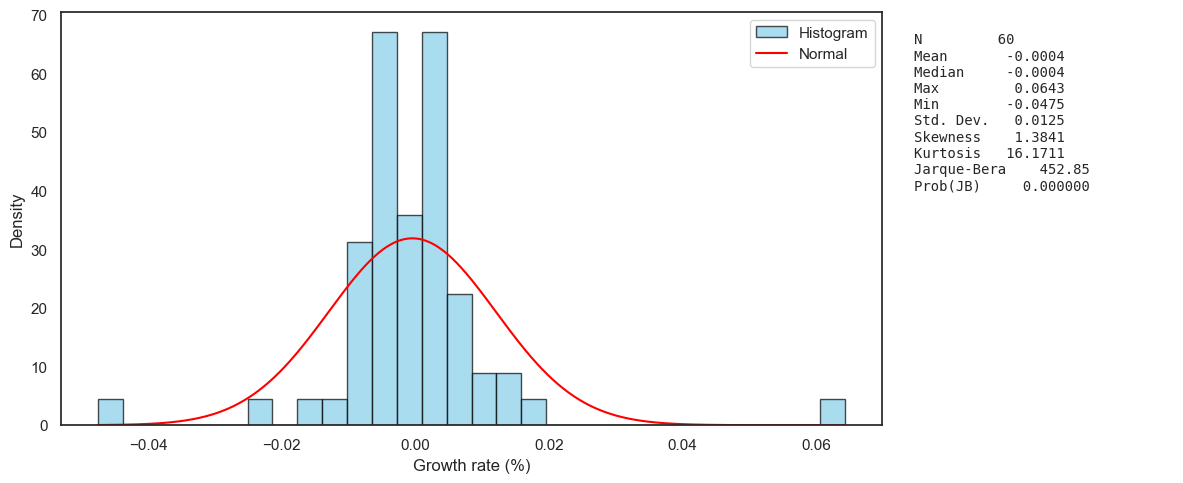

In [191]:
test_normality(pred_errors_ao)

## DM test

In [192]:
import numpy as np
from scipy import stats

# err_no and err_ao are forecast errors: actual minus forecast
e1 = pred_errors_no
e2 = pred_errors_ao

# squared-error differential
d = e1**2 - e2**2
T = len(d)
d_mean = d.mean()

var_d = np.var(d)

# Diebold–Mariano statistic
dm_stat = d_mean / np.sqrt(var_d / T)
p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))

print(f"DM stat = {dm_stat:.3f},  p-value = {p_value:.3f}")

DM stat = -0.384,  p-value = 0.701


## Mincer regression (first with AO, second without)

In [193]:
# build design matrix
import statsmodels.api as sm

y_actual = test['y']        
y_forecast = fc_ao   

X = sm.add_constant(y_forecast) 


mz_mod = sm.OLS(y_actual, X).fit()
print(mz_mod.summary())

print("")
print("Results of the Mincer regression:")
print("Alpha: " + str((-0.0010  - 0)/0.001))
print("Beta_1: " + str((0.7412 - 1)/0.106))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     49.29
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           2.71e-09
Time:                        23:42:38   Log-Likelihood:                 181.15
No. Observations:                  60   AIC:                            -358.3
Df Residuals:                      58   BIC:                            -354.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.294      0.7

In [194]:
# build design matrix
import statsmodels.api as sm

y_actual = test['y']        
y_forecast = fc_no   

X = sm.add_constant(y_forecast) 


mz_mod = sm.OLS(y_actual, X).fit()
print(mz_mod.summary())

print("")
print("Results of the Mincer regression:")
print("Alpha: " + str((-0.0004 - 0)/0.002))
print("Beta_1: " + str((0.8173 - 1)/0.121))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     45.53
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           7.78e-09
Time:                        23:42:38   Log-Likelihood:                 180.08
No. Observations:                  60   AIC:                            -356.2
Df Residuals:                      58   BIC:                            -352.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.247      0.8

# COVID-19 EXCLUDED 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   69
Model:               SARIMAX(3, 0, 0)   Log Likelihood                 242.123
Date:                Tue, 17 Jun 2025   AIC                           -474.246
Time:                        23:42:38   BIC                           -463.298
Sample:                    12-31-1992   HQIC                          -469.920
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.001      0.133      0.894      -0.002       0.002
ar.L1          0.7565      0.095      7.957      0.000       0.570       0.943
ar.L2          0.2100      0.142      1.475      0.1

/opt/anaconda3/envs/test/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


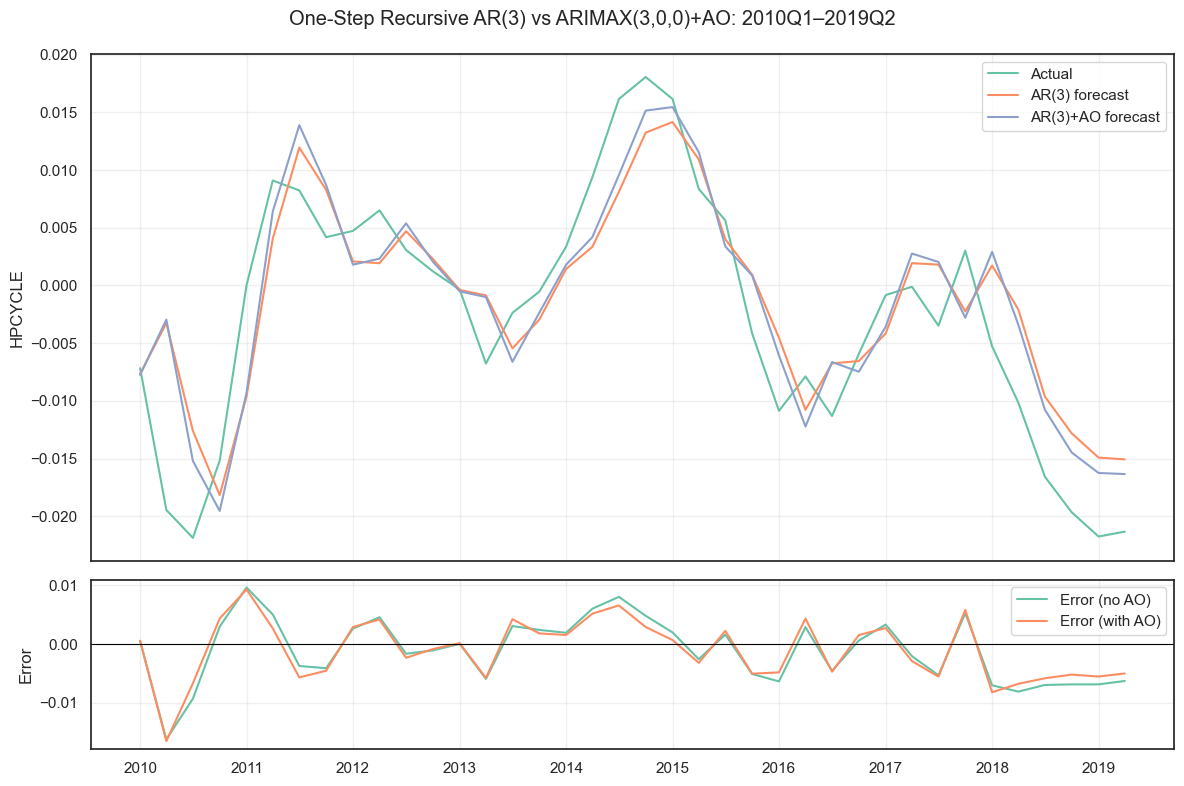

In [195]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ------------------------------------------------------------------
# 1│  READ THE DATA
# ------------------------------------------------------------------
FILE   = Path("RSGCS.xlsx")  # Excel file path
SHEET  = 0                     # sheet index/name
SERIES = "HPCYCLE"           # series column

raw = pd.read_excel(FILE, sheet_name=SHEET)
raw.iloc[:, 0] = pd.PeriodIndex(raw.iloc[:, 0].astype(str), freq="Q")
raw = raw.set_index(raw.columns[0]).sort_index()
y = raw[SERIES].astype(float)

# ------------------------------------------------------------------
# 2│  BUILD LAGS AND AO DUMMY
# ------------------------------------------------------------------
lagged = pd.concat([
    y.shift(i).rename(f"lag{i}") for i in range(1, 4)
], axis=1)
# Create AO dummy as a Series, not a numpy array
date_ao = pd.Period("2000Q1", freq="Q")
dummy_ao = pd.Series((y.index == date_ao).astype(int),
                     index=y.index, name="AO")

data = pd.concat([y.rename("y"), lagged, dummy_ao], axis=1).dropna()

# ------------------------------------------------------------------
# 3│  TRAIN / TEST SPLIT
# ------------------------------------------------------------------
train = data.loc[:"2009Q4"]
test  = data.loc["2010Q1":"2019Q2"]

# ------------------------------------------------------------------
# 4│  FIT AR(3) WITHOUT AO (SARIMAX)
# ------------------------------------------------------------------
mod_no = sm.tsa.SARIMAX(
    endog=train["y"],
    order=(3,0,0), trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_no = mod_no.fit(disp=False)
print(res_no.summary())
params_no = res_no.params  # contains const, ar.L1, ar.L2, ar.L3

# ------------------------------------------------------------------
# 5│  RECURSIVE ONE-STEP FORECASTS (NO AO)
# ------------------------------------------------------------------
y_hist = train["y"].tolist()
fc_no = []
for t in range(len(test)):
    y1, y2, y3 = y_hist[-1], y_hist[-2], y_hist[-3]
    f = (params_no['intercept']
         + params_no['ar.L1'] * y1
         + params_no['ar.L2'] * y2
         + params_no['ar.L3'] * y3)
    fc_no.append(f)
    # update history with actual
    y_hist.append(test['y'].iloc[t])
fc_no = pd.Series(fc_no, index=test.index)

# ------------------------------------------------------------------
# 6│  FIT ARIMAX WITH AO (SARIMAX + EXOG)
# ------------------------------------------------------------------
mod_ao = sm.tsa.SARIMAX(
    endog=train["y"],
    exog=train[["AO"]],
    order=(3,0,0), trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_ao = mod_ao.fit(disp=False)
print(res_ao.summary())
params_ao = res_ao.params  # contains const, ar.*, exog.AO

# ------------------------------------------------------------------
# 7│  RECURSIVE ONE-STEP FORECASTS (WITH AO)
# ------------------------------------------------------------------
y_hist = train["y"].tolist()
fc_ao = []
for t in range(len(test)):
    y1, y2, y3 = y_hist[-1], y_hist[-2], y_hist[-3]
    # AO dummy = 0 in forecast period
    ao = 0
    f = (params_ao['intercept']
         + params_ao['ar.L1'] * y1
         + params_ao['ar.L2'] * y2
         + params_ao['ar.L3'] * y3
         + params_ao['AO'] * ao)
    fc_ao.append(f)
    y_hist.append(test['y'].iloc[t])
fc_ao = pd.Series(fc_ao, index=test.index)

# ------------------------------------------------------------------
# 8│  COMPUTE FORECAST ERRORS
# ------------------------------------------------------------------
err_no = test['y'] - fc_no
err_ao = test['y'] - fc_ao

# ------------------------------------------------------------------
# 9│  PLOT RESULTS
# ------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True,
                                gridspec_kw={"height_ratios": [3, 1]})

# top: actual vs forecasts
ax1.plot(test.index.to_timestamp(), test['y'], label='Actual')
ax1.plot(fc_no.index.to_timestamp(), fc_no, label='AR(3) forecast')
ax1.plot(fc_ao.index.to_timestamp(), fc_ao, label='AR(3)+AO forecast')
ax1.set_ylabel(SERIES)
ax1.legend()
ax1.grid('--', alpha=0.3)

# bottom: errors
ax2.plot(err_no.index.to_timestamp(), err_no, label='Error (no AO)')
ax2.plot(err_ao.index.to_timestamp(), err_ao, label='Error (with AO)')
ax2.axhline(0, color='k', lw=0.8)
ax2.set_ylabel('Error')
ax2.legend()
ax2.grid('--', alpha=0.3)

fig.suptitle('One-Step Recursive AR(3) vs ARIMAX(3,0,0)+AO: 2010Q1–2019Q2')
plt.tight_layout()
plt.show()

pred_errors_no = test['y'] - fc_no
pred_errors_ao = test['y'] - fc_ao

(0.6963276827633523, 0.7059831974756463, -0.3144589660156474, 2.7896475822039366)


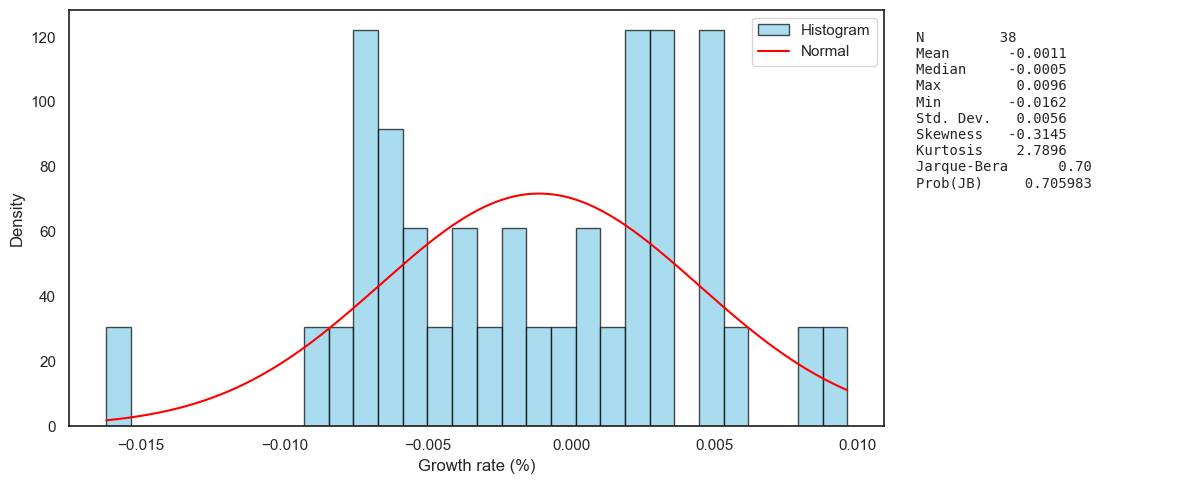

(1.0707818404862968, 0.5854403849082463, -0.3985039208143521, 3.202637035257404)


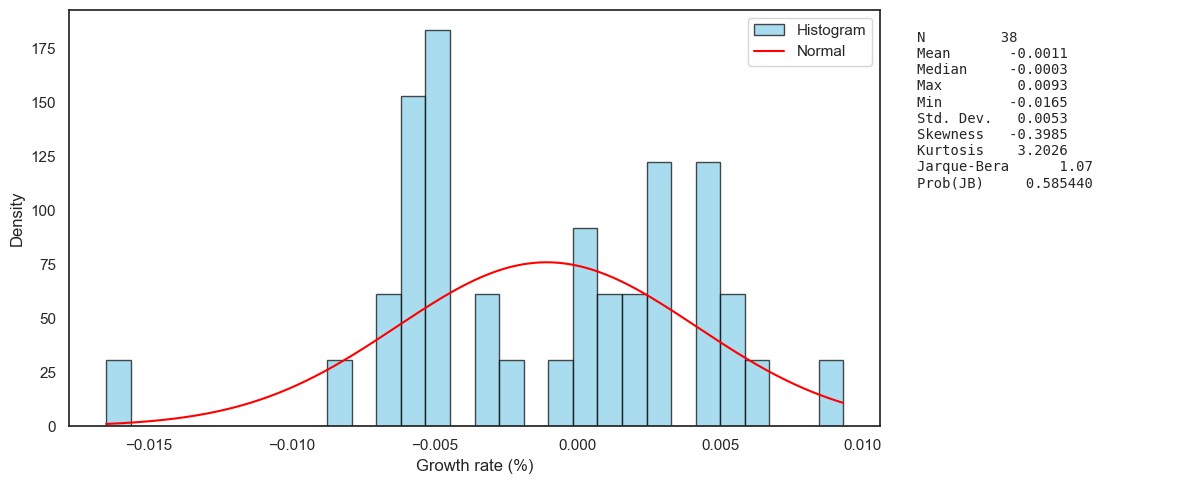

In [196]:
test_normality(pred_errors_no)
test_normality(pred_errors_ao)

## DM test

In [197]:
import numpy as np
from scipy import stats

# err_no and err_ao are forecast errors: actual minus forecast
e1 = pred_errors_no
e2 = pred_errors_ao

# squared-error differential
d = e1**2 - e2**2
T = len(d)
d_mean = d.mean()

var_d = np.var(d)

# Diebold–Mariano statistic
dm_stat = d_mean / np.sqrt(var_d / T)
p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))

print(f"DM stat = {dm_stat:.3f},  p-value = {p_value:.3f}")

DM stat = 1.713,  p-value = 0.087


## Mincer regression (first with AO, second without)

In [198]:
# build design matrix
import statsmodels.api as sm

y_actual = test['y']        
y_forecast = fc_ao   

X = sm.add_constant(y_forecast) 


mz_mod = sm.OLS(y_actual, X).fit()
print(mz_mod.summary())

print("")
print("Results of the Mincer regression:")
print("Alpha: " + str((-0.0010  - 0)/0.001))
print("Beta_1: " + str((1.0515 - 1)/0.097))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     118.3
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           6.30e-13
Time:                        23:42:40   Log-Likelihood:                 146.19
No. Observations:                  38   AIC:                            -288.4
Df Residuals:                      36   BIC:                            -285.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.001     -1.146      0.2

In [199]:
# build design matrix
import statsmodels.api as sm

y_actual = test['y']        
y_forecast = fc_no   

X = sm.add_constant(y_forecast) 


mz_mod = sm.OLS(y_actual, X).fit()
print(mz_mod.summary())

print("")
print("Results of the Mincer regression:")
print("Alpha: " + str((-0.0009 - 0)/0.001))
print("Beta_1: " + str((1.1565  - 1)/ 0.111 ))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     108.2
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           2.16e-12
Time:                        23:42:40   Log-Likelihood:                 144.90
No. Observations:                  38   AIC:                            -285.8
Df Residuals:                      36   BIC:                            -282.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -0.984      0.3